In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Normal

import random
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import celluloid
# import seaborn as sns

save = False

from os.path import expanduser

from franka.franka_utils import *

    
save = False
path = os.getcwd()
# Use this path if Loading Dataset
int_dir = os.path.dirname(path) 
home = os.path.dirname(int_dir) + "/data/grayscale/data/"
print(home)
print(home)



/media/enrique/Elements/


In [2]:
# Load test data

dir_path = home + "test_data/"
# Load Pickled Data
file_path = dir_path + "data_eval_dict.pickle"
with open(file_path, 'rb') as f: 
    data_dict = pickle.load(f, encoding="bytes")
    print(data_dict.keys())
testobj1 = data_dict['obj_loc']
testobj2 = data_dict['obj2_loc']
testtraj = data_dict['path']
testbuffer = data_dict['buffer']
test_env_traj = data_dict['env_path']
test_env_lim = data_dict['tray_lim']
test_klerg_lim = data_dict['klerg_lim']
print(testobj1, testobj2)

dict_keys(['path', 'buffer', 'env_path', 'obj_loc', 'obj2_loc', 'tray_lim', 'klerg_lim'])
(-0.1, -0.1, -0.4) (0.1, -0.1, -0.6)


In [3]:
ablation_dir = home + 'klerg_ablation/time_horizon/'
horizon_list = [5,10,20,50]



In [4]:
klerg_paths = []
klerg_epaths = []
for s in range(len(horizon_list)):
    dir_path1 = ablation_dir + str(horizon_list[s])+ '/'
    # Load Pickled Data
    file_path1 = dir_path1 + "data_eval_dict.pickle"
    with open(file_path1, 'rb') as f: 
        data_dict1 = pickle.load(f, encoding="bytes")
    traj1 = data_dict1['path']
    env_traj1 = data_dict1['env_path']
    klerg_paths.append(traj1)
    klerg_epaths.append(env_traj1)

    

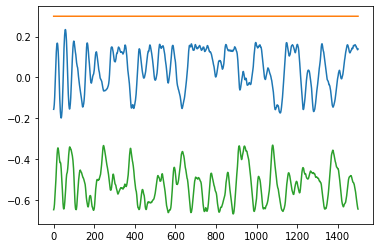

In [5]:
    klerg_epaths[0].shape
plt.plot(klerg_epaths[0])

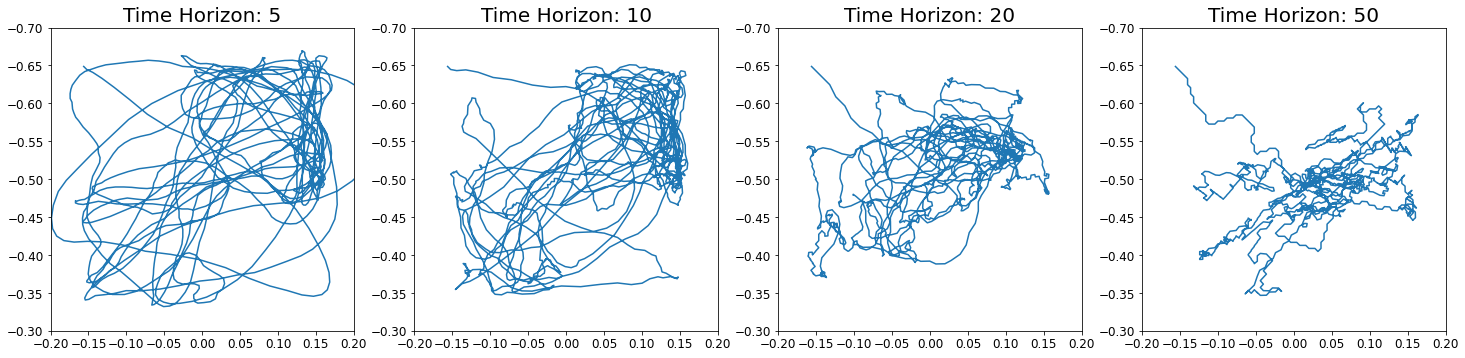

In [16]:
fig,ax = plt.subplots(1,4, figsize=(25,18))
fig.patch.set_facecolor('white')
for s in range(len(horizon_list)):
    env_traj1 = klerg_epaths[s]
    title = 'Time Horizon: '+ str(horizon_list[s])
    ax[s].plot(env_traj1[:,0], env_traj1[:,2])
    ax[s].axis('square')
    ax[s].set_xlim(test_env_lim[0])
    ax[s].set_ylim(test_env_lim[1])
    ax[s].set_title(title, fontsize = 20.0)
    ax[s].tick_params(axis='both', which='major', labelsize=12)


# plt.plot(testobj1[0], testobj1[2],'k.')
# plt.plot(testobj2[0], testobj2[2],'g.')
# plt.plot(test_env_traj[:,0], test_env_traj[:,2], 'r.')
plt.savefig('klerg_ablation_timehorizon_traj.pdf')
plt.show()

In [9]:
def mseloss(A,B): return np.square(np.subtract(A, B)).mean()
klerg_loss = []
for s in range(len(horizon_list)):
    print("samples:", s)
    dir_path1 = ablation_dir + str(horizon_list[s])+ '/'

    
    # Load Pytorch Models
    # model1 = torch.load("model_int_check.pth")
    model1 = torch.load(dir_path1 + "model_final_postlearning.pth")
    model1.eval()

    
    loss1 = []
    mseloss1 = [None]*len(testbuffer)

    with torch.no_grad():
        for cp in range(50,15400,50):
            PATH =  dir_path1 + "model_checkpoint_iter"+str(cp)+".pth"
            model1.load_state_dict(torch.load(PATH)['state_dict'])
            model1.eval()

            xt = np.expand_dims(testbuffer[0][0], axis=0)
            yt = np.expand_dims(np.mean(testbuffer[0][1][:,::2,::2],axis=0).flatten(), axis=0)

            xt = torch.FloatTensor(xt)#.squeeze()
            yt = torch.FloatTensor(yt)#.squeeze()
            _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
            z_samples1 = model1.reparameterize(z_mu1, z_logvar1)


            ind = 0
            for i in range(int(len(testbuffer)/2)):

                xc = np.expand_dims(testbuffer[ind][0], axis=0)
                xc = torch.FloatTensor(xc)#.squeeze()

                y_pred = model1.decode(torch.cat([z_samples1, xc], dim=1))
                img_pred1 = y_pred[:,1:]
                ycheck1 = img_pred1[0].detach().numpy().reshape((38,38)).T
                mseloss1[ind] = mseloss(ycheck1, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)
                ind +=1

            xt = np.expand_dims(testbuffer[ind][0], axis=0)
            yt = np.expand_dims(np.mean(testbuffer[ind][1][:,::2,::2],axis=0).flatten(), axis=0)

            xt = torch.FloatTensor(xt)#.squeeze()
            yt = torch.FloatTensor(yt)#.squeeze()

            _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
            z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

            for i in range(int(len(testbuffer)/2)):
                xc = np.expand_dims(testbuffer[ind][0], axis=0)
                xc = torch.FloatTensor(xc)#.squeeze()

                y_pred = model1.decode(torch.cat([z_samples1, xc], dim=1))
                img_pred1 = y_pred[:,1:]
                ycheck1 = img_pred1[0].detach().numpy().reshape((38,38)).T
                mseloss1[ind] = mseloss(ycheck1, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)

                ind += 1

            loss1.append(mseloss1.copy())
            
    loss1 = np.array(loss1)

    klerg_loss.append(loss1)


samples: 0
samples: 1
samples: 2
samples: 3


In [10]:
klerg_loss = np.array(klerg_loss)

In [11]:
print(klerg_loss.shape)

(4, 307, 18)


In [12]:
klerg_loss = np.sum(klerg_loss, axis=2)

In [13]:
print(klerg_loss.shape)

(4, 307)


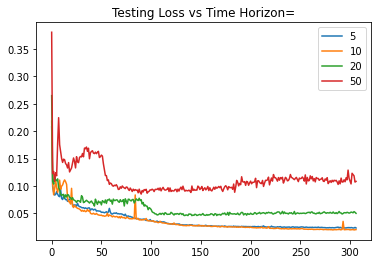

In [15]:
fig, ax = plt.subplots()
for i in range(len(horizon_list)):
    ax.plot(klerg_loss[i], label=str(horizon_list[i]))
plt.legend()
plt.title('Testing Loss vs Time Horizon')
plt.savefig('klerg_ablation_horizon_loss.pdf')
plt.show()
    